In this notebook I will create several models for classification of mice brain cells using single-cell RNA sequence data from [brainimagelibrary](https://download.brainimagelibrary.org/cf/1c/cf1c1a431ef8d021/processed_data/).

* We have 3 cell types
* 280186 cells x 254 genes

# Imports and data loading

In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedGroupKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, roc_curve

In [2]:
from sklearn.decomposition import PCA
import umap
import xgboost as xgb
import optuna
import joblib

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

In [4]:
cell_labels = pd.read_csv("cell_labels.csv") # Метки классов (колонка `class_label`)
adata = sc.read_h5ad("counts.h5ad") # Экспрессии + метаданные

let's take a look at the data

In [5]:
cell_labels.head(3)

,Unnamed: 0,sample_id,slice_id,class_label,subclass,label
0,10000143038275111136124942858811168393,mouse2_sample4,mouse2_slice31,Other,Astro,Astro_1
1,100001798412490480358118871918100400402,mouse2_sample5,mouse2_slice160,Other,Endo,Endo
2,100006878605830627922364612565348097824,mouse2_sample6,mouse2_slice109,Other,SMC,SMC


In [6]:
cell_labels['class_label'].unique()

array(['Other', 'Glutamatergic', 'GABAergic'], dtype=object)

In [7]:
cell_labels['subclass'].unique().shape

(24,)

In [8]:
cell_labels.query('class_label == "GABAergic"')['subclass'].unique()

array(['Sst', 'Sncg', 'Vip', 'Pvalb', 'Lamp5'], dtype=object)

In [9]:
cell_labels.query('class_label == "Glutamatergic"')['subclass'].unique()

array(['L2/3 IT', 'L6 CT', 'L4/5 IT', 'L5 ET', 'L5 IT', 'L6 IT',
       'L6 IT Car3', 'L5/6 NP', 'L6b'], dtype=object)

In [10]:
cell_labels.query('class_label == "Other"')['subclass'].unique()

array(['Astro', 'Endo', 'SMC', 'VLMC', 'Peri', 'Micro', 'Oligo', 'PVM',
       'OPC', 'other'], dtype=object)

So we have 3 cell classes and 24 subclasses.

In [11]:
cell_labels.shape

(280186, 6)

In [12]:
adata.X.shape

(280186, 254)

In [13]:
cell_labels.groupby('class_label').agg('count')

,Unnamed: 0,sample_id,slice_id,subclass,label
class_label,,,,,
GABAergic,18300,18300,18300,18300,18300
Glutamatergic,155831,155831,155831,155831,155831
Other,106055,106055,106055,106055,106055


The dataset is not balanced, so I have to be careful when splitting data for test, train, and validation parts. Otherwise it won't matter with such a large dataset.

In [14]:
cell_labels['class'] = cell_labels['class_label'].astype('category').cat.codes # create column with numeric codes for classes.

# We can try to reduce the data dimensionality

## UMAP

In [47]:
reducer = umap.UMAP()
reducer.fit(adata.X)
embedding = reducer.transform(adata.X)

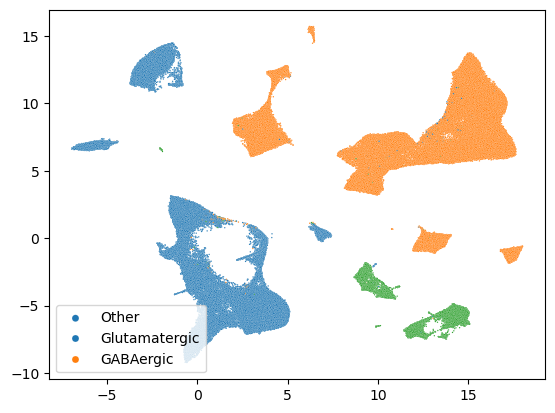

In [61]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=cell_labels['class_label'], s=1)
plt.legend(labels=cell_labels['class_label'].unique(), loc='lower left', markerscale=5);

Looks like UMAP does very nice job here

## PCA

In [18]:
pca = PCA(n_components=30)
pca.fit(adata.X)

PCA(n_components=30)

<Axes: >

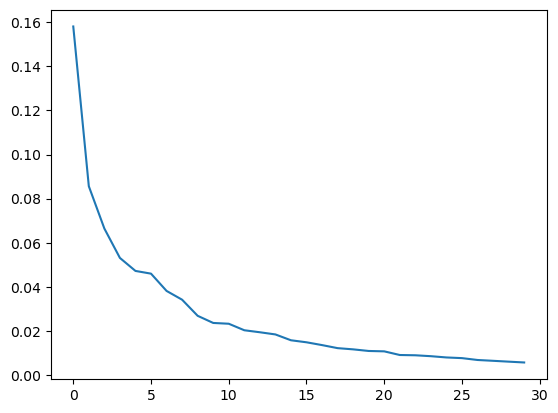

In [14]:
sns.lineplot(pca.explained_variance_ratio_)

In [125]:
pca.explained_variance_ratio_.sum()

0.8168049600706969

In [19]:
X_pca = pca.transform(adata.X)

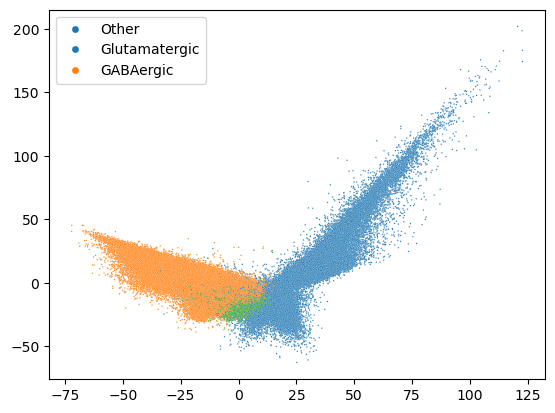

In [127]:
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=cell_labels['class_label'], s=1)
plt.legend(labels=cell_labels['class_label'].unique(), loc='upper left', markerscale=5);

# divide data for train and test parts

In [15]:
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(adata.X, cell_labels['class'], cell_labels['subclass'], stratify=cell_labels['class_label'])

And after that we'll use cross-folding to split data for training and validation data, groupped by subclass.

In [16]:
gcv = StratifiedGroupKFold(n_splits=5)

In [20]:
X_pca_train, X_pca_test, y_pca_train, y_pca_test, groups_pca_train, groups_pca_test = train_test_split(X_pca, cell_labels['class'], cell_labels['subclass'], stratify=cell_labels['class_label'])

# Preliminary tests to choose a model

## logistic regression

In [69]:
lr_model = LogisticRegression()

In [85]:
cross_val_score(lr_model, X_train, y_train, scoring='accuracy', cv=gcv, groups=groups_train, n_jobs=-1)

array([0.97174083, 0.94139113, 0.99036614, 0.89092026, 0.98128591])

In [106]:
cross_val_score(lr_model, X_pca_train, y_pca_train, scoring='accuracy', cv=gcv, groups=groups_pca_train, n_jobs=-1)

array([0.83463801, 0.99001576, 0.98009062, 0.732255  , 0.92276694])

## Random forest

In [90]:
forest_model = RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [91]:
cross_val_score(forest_model, X_train, y_train, scoring='accuracy', cv=gcv, groups=groups_train, n_jobs=-1)

array([0.99375163, 0.92007077, 0.98823406, 0.97114252, 0.98197726])

In [93]:
cross_val_score(forest_model, X_pca_train, y_pca_train, scoring='accuracy', cv=gcv, groups=groups_pca_train, n_jobs=-1)

array([0.99636862, 0.92416078, 0.9834015 , 0.95998174, 0.99138447])

## XGBoost

In [111]:
xgb_model = xgb.XGBClassifier(device='cuda')

In [113]:
cross_val_score(xgb_model, X_train, y_train, scoring='accuracy', cv=gcv, groups=groups_train, n_jobs=-1)

array([0.99756495, 0.91445559, 0.99310508, 0.89821785, 0.98005732])

In [112]:
cross_val_score(xgb_model, X_pca_train, y_pca_train, scoring='accuracy', cv=gcv, groups=groups_pca_train, n_jobs=-1)

array([0.92455   , 0.96192853, 0.97680143, 0.9481941 , 0.98571701])

# Optimization of hyperparameters with optuna

For tree-based models reduced dimensions table gives the same cross-valuation accuracy score as full table. However calculation time was greatly reduced. I suggest to optimize XGBoost hyperparameters with optuna to obtain better model.

In [153]:
y_pca_train = y_pca_train.to_numpy()

In [ ]:
def objective(trial):
    cv = StratifiedGroupKFold(n_splits=3, shuffle=True)
    params = {
        "verbosity": 0,
        "objective": "multi:softmax",
        "booster": "gbtree", # I decided to limit this hyperparameter only for gbtree since it got better results earlier.
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        # maximum depth of the tree, signifies complexity of the tree.
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        # minimum child weight, larger the term more conservative the tree.
        "min_child_weight": trial.suggest_int("min_child_weight", 2, 10),
        "eta": trial.suggest_float("eta", 1e-8, 1.0, log=True),
        # defines how selective algorithm is.
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    }
    
    # pruning_callback = optuna.integration.XGBoostPruningCallback(trial, 'validation-error')
    model = xgb.XGBClassifier(**params, n_jobs=-1)
    score = cross_val_score(model, X_pca_train, y_pca_train, scoring='accuracy', cv=cv, groups=groups_pca_train, n_jobs=-1)
    # scores = []
    # for train_index, valid_index in cv.split(X_pca_train, y_pca_train, groups_pca_train):
    #     # assign new names for train and validation sets
    #     train_x, valid_x = X_pca_train[train_index], X_pca_train[valid_index]
    #     train_y, valid_y = y_pca_train[train_index], y_pca_train[valid_index]
    #     # change those to xgb.DMatrix
    #     dtrain = xgb.DMatrix(train_x, label=train_y)
    #     dvalid = xgb.DMatrix(valid_x, label=valid_y)
    #     # and train the model
    #     model = xgb.train(params, dtrain, evals=[(dvalid, 'validation')], callbacks=[pruning_callback])
        
    #     preds = model.predict(dvalid)
    #     pred_labels = np.rint(preds)
    #     score = accuracy_score(valid_y, pred_labels)
    #     scores.append(score)

    return np.mean(score)

In [ ]:
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction='maximize')
study.optimize(objective, n_trials=100)
joblib.dump(study, "/kaggle/working/study_xgb.pkl") #save to file

[I 2024-04-11 07:20:21,559] A new study created in memory with name: no-name-aea54e8c-5c41-458f-8839-c3b8d9ca576b
[I 2024-04-11 07:23:00,676] Trial 0 finished with value: 0.9238240275434156 and parameters: {'lambda': 6.283903287511062e-06, 'alpha': 0.0022606594023373283, 'subsample': 0.877032428497428, 'colsample_bytree': 0.39755957543979553, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.00014271673399926312, 'gamma': 0.010970679774515235, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.9238240275434156.
[I 2024-04-11 07:27:03,526] Trial 1 finished with value: 0.9579486505316025 and parameters: {'lambda': 0.00015759690631702452, 'alpha': 0.0014456743590459831, 'subsample': 0.8848558899079879, 'colsample_bytree': 0.5187170298167147, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.20477564093236447, 'gamma': 0.615891015869714, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.9579486505316025.
[I 2024-04-11 07:28:22,925] Trial 2 finished with value: 0.79455000202928

['/kaggle/working/study_xgb.pkl']

In [ ]:
study.best_params

{'lambda': 0.0010041351651543825,
 'alpha': 0.005709987636930291,
 'subsample': 0.9794808845466684,
 'colsample_bytree': 0.771828220298,
 'max_depth': 7,
 'min_child_weight': 3,
 'eta': 0.002806057913561531,
 'gamma': 9.457239856021425e-07,
 'grow_policy': 'depthwise'}

In [36]:
params = {"verbosity": 0,
"objective": "multi:softmax",
'booster': 'gbtree',
'lambda': 0.0010041351651543825,
 'alpha': 0.005709987636930291,
 'subsample': 0.9794808845466684,
 'colsample_bytree': 0.771828220298,
 'max_depth': 7,
 'min_child_weight': 3,
 'eta': 0.002806057913561531,
 'gamma': 9.457239856021425e-07,
 'grow_policy': 'depthwise'}

In [37]:
xgb_model = xgb.XGBClassifier(**params, n_jobs=-1)

In [140]:
cross_val_score(xgb_model, X_pca_train, y_pca_train, scoring='accuracy', cv=gcv, groups=groups_pca_train, n_jobs=-1)

array([0.99730616, 0.91841487, 0.95642461, 0.99172628, 0.97445581])

In [141]:
np.mean([0.99730616, 0.91841487, 0.95642461, 0.99172628, 0.97445581])

0.9676655460000001

In [38]:
xgb_model.fit(X_train, y_train)

XGBClassifier(alpha=0.005709987636930291, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.771828220298, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.002806057913561531, eval_metric=None, feature_types=None,
              gamma=9.457239856021425e-07, grow_policy='depthwise',
              importance_type=None, interaction_constraints=None,
              lambda=0.0010041351651543825, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, ...)

In [39]:
y_pred_xgb = xgb_model.predict(X_test)

In [40]:
accuracy_score(y_test, y_pred_xgb)

0.9902922323582737

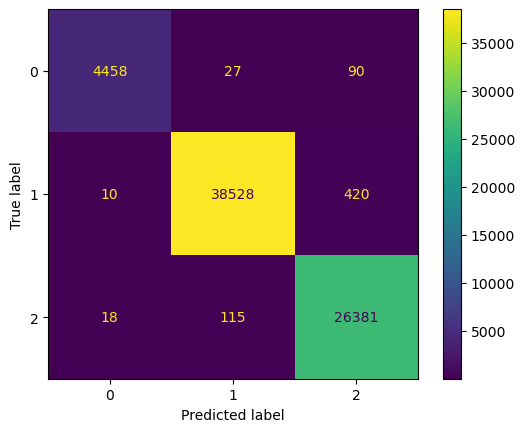

In [41]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_xgb)).plot()

It took some time for optimization, however we got a model with 99% accuracy which is not bad.

# neural network

We can try to use autoencoder for classification of these kind of data

In [50]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=groups_train) # We'll require validation dataet here.

In [51]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [52]:
class CustomTableDataset(Dataset):
    def __init__(self, table, annotation):
        self.table = table
        self.y = annotation
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        values = torch.tensor(self.table[idx]).to(device)
        y = torch.tensor(self.y[idx]) # y may stay on cpu
        return values, y

In [53]:
train_dataset = CustomTableDataset(X_train, y_train.values)
valid_dataset = CustomTableDataset(X_val, y_val.values)
test_dataset = CustomTableDataset(X_test, y_test.values)

In [54]:
train_dataloader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1000, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1000, shuffle=True)

training functions

In [24]:
def train_autoencoder(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        output = model(X)
        loss = loss_fn(output, X)
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            print(batch, loss.item())

    train_loss = train_loss / len(dataloader)
    return train_loss

In [25]:
def train_classifier(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss = []
    train_acc = []

    for batch, (X, y) in enumerate(dataloader):
        y = y.type(torch.LongTensor)
        pred = model(X)
        loss = loss_fn(pred, y.to(device))
        train_loss += [loss.item()]
        acc = accuracy_score(y, pred.argmax(1).cpu())
        train_acc += [acc]

        model.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            print(batch, loss.item(), acc)

    return np.mean(train_loss), np.mean(train_acc)

In [48]:
def test_classifier(dataloader, model, loss_fn):
    model.eval()
    accuracy = []

    for X, y in dataloader:
        pred = model(X).argmax(1).cpu()
        y = y.numpy()
        acc = accuracy_score(y, pred)
        accuracy += [acc]
    return np.mean(accuracy)

## create and train a model

In [22]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(254, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12)
        )
        self.decoder = nn.Sequential(
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 254),
            nn.ReLU() # our data starts from 0
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [37]:
nn_model = Autoencoder().to(device)
nn_model

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=254, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=254, bias=True)
    (5): ReLU()
  )
)

In [38]:
loss_fn = nn.MSELoss() # we'll use mean squared error for autoencoder training
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-2)
epochs = 3

In [39]:
t_loss = []
for e in range(epochs):
    t_loss += [train_autoencoder(train_dataloader, nn_model, loss_fn, optimizer)]

0 15.171126365661621
10 13.746515274047852
20 11.39967155456543
30 10.286766052246094
40 8.421171188354492
50 7.354395866394043
60 6.514671802520752
70 6.131265640258789
80 5.661256313323975
90 4.749446868896484
100 4.640389919281006
110 4.442727565765381
120 4.727511405944824
130 4.147714138031006
140 3.9529242515563965
150 4.236810684204102
0 4.096574783325195
10 3.7040088176727295
20 3.705909490585327
30 3.651221990585327
40 3.7215237617492676
50 3.7378532886505127
60 3.3252501487731934
70 3.476243734359741
80 3.474565029144287
90 3.566697359085083
100 3.3909449577331543
110 3.6624884605407715
120 3.276492118835449
130 3.429138422012329
140 3.4849538803100586
150 3.233903408050537
0 3.0780985355377197
10 3.0784223079681396
20 3.5365655422210693
30 3.2488441467285156
40 3.2928149700164795
50 3.2129135131835938
60 3.314234733581543
70 3.1468350887298584
80 3.2553088665008545
90 3.1258907318115234
100 2.8721959590911865
110 3.009446859359741
120 2.952857494354248
130 3.3236141204833984

In [41]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-3

for e in range(epochs):
    t_loss += [train_autoencoder(train_dataloader, nn_model, loss_fn, optimizer)]

0 3.089932918548584
10 2.8168439865112305
20 2.7951807975769043
30 3.0385265350341797
40 2.8604512214660645
50 2.7528977394104004
60 2.787076234817505
70 2.7555596828460693
80 2.8782589435577393
90 2.798860788345337
100 2.830695867538452
110 2.628309726715088
120 2.81239914894104
130 2.989506959915161
140 2.9272799491882324
150 2.7914533615112305
0 2.7515437602996826
10 2.714277505874634
20 2.678056001663208
30 2.9733169078826904
40 2.8216757774353027
50 2.8318395614624023
60 2.8823254108428955
70 2.706528663635254
80 2.681565523147583
90 2.9481303691864014
100 3.029783248901367
110 2.7222156524658203
120 2.793126106262207
130 2.6266822814941406
140 2.7214767932891846
150 2.6945319175720215
0 2.7218518257141113
10 2.880566120147705
20 2.808521032333374
30 2.824584722518921
40 2.610515832901001
50 2.8434643745422363
60 2.6962738037109375
70 2.6305670738220215
80 2.7769391536712646
90 2.7875945568084717
100 2.763869524002075
110 2.5861716270446777
120 2.934211492538452
130 2.710052728652

In [43]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-4

for e in range(epochs):
    t_loss += [train_autoencoder(train_dataloader, nn_model, loss_fn, optimizer)]

0 3.020028591156006
10 2.8248727321624756
20 2.5771234035491943
30 2.766871929168701
40 2.756601572036743
50 2.65334153175354
60 2.7224292755126953
70 2.727898597717285
80 3.120509624481201
90 2.713948965072632
100 2.6633124351501465
110 2.7144994735717773
120 2.7480859756469727
130 2.745591163635254
140 2.7495949268341064
150 2.7858941555023193
0 2.655287742614746
10 2.718033790588379
20 2.7686102390289307
30 2.6808066368103027
40 2.925421714782715
50 2.534687042236328
60 2.7861127853393555
70 2.9308021068573
80 2.684560537338257
90 2.9541969299316406
100 2.691079616546631
110 2.668520212173462
120 2.65432071685791
130 2.644620656967163
140 2.8967342376708984
150 2.725456714630127
0 2.778049945831299
10 2.9317657947540283
20 2.967966079711914
30 2.7600624561309814
40 2.7017457485198975
50 2.666041851043701
60 2.734013319015503
70 2.9599220752716064
80 2.673997402191162
90 2.7870941162109375
100 2.5056161880493164
110 2.7611520290374756
120 2.715592861175537
130 2.5687241554260254
140 

In [45]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 5e-4

for e in range(epochs):
    t_loss += [train_autoencoder(train_dataloader, nn_model, loss_fn, optimizer)]

0 2.7174625396728516
10 2.7877724170684814
20 2.6872663497924805
30 2.7739603519439697
40 2.8221023082733154
50 2.627924680709839
60 2.9587337970733643
70 2.731732130050659
80 2.648383855819702
90 2.852050304412842
100 2.6737849712371826
110 2.872148036956787
120 2.8886101245880127
130 2.6272923946380615
140 2.7518715858459473
150 2.6579084396362305
0 2.7191214561462402
10 2.923862934112549
20 2.849217176437378
30 2.8253071308135986
40 2.699946880340576
50 2.5973196029663086
60 2.6508214473724365
70 2.7901723384857178
80 2.6540865898132324
90 2.7488980293273926
100 2.7725558280944824
110 2.7407279014587402
120 2.7477338314056396
130 2.8389124870300293
140 2.563704252243042
150 2.722008228302002
0 2.748582124710083
10 2.595238447189331
20 2.678422451019287
30 2.7243385314941406
40 2.61639666557312
50 2.5436341762542725
60 2.79594349861145
70 2.749183416366577
80 2.618814468383789
90 2.5469655990600586
100 2.905900001525879
110 2.7352466583251953
120 2.748493194580078
130 2.8308608531951

In [48]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 5e-5

for e in range(epochs):
    t_loss += [train_autoencoder(train_dataloader, nn_model, loss_fn, optimizer)]

0 2.722372531890869
10 2.678788185119629
20 2.800957679748535
30 2.7505784034729004
40 2.8107857704162598
50 2.52997088432312
60 2.6871817111968994
70 2.4741594791412354
80 2.696660041809082
90 2.6233577728271484
100 2.684952974319458
110 2.738377094268799
120 2.705031156539917
130 2.7146360874176025
140 2.8251757621765137
150 2.632354259490967
0 2.502290725708008
10 2.7065014839172363
20 2.5665457248687744
30 2.8235676288604736
40 2.677058458328247
50 2.8266661167144775
60 2.687361717224121
70 2.796739101409912
80 2.535848379135132
90 2.7376186847686768
100 2.704481363296509
110 2.714672327041626
120 2.6233608722686768
130 2.6026341915130615
140 2.5665225982666016
150 2.6593403816223145
0 2.6054444313049316
10 2.6987557411193848
20 2.8142290115356445
30 2.846712589263916
40 2.614819049835205
50 2.5854759216308594
60 2.46889328956604
70 2.7768518924713135
80 2.49298357963562
90 2.8529956340789795
100 2.6008756160736084
110 2.5410330295562744
120 2.7931859493255615
130 2.756876230239868

In [50]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-4

for e in range(epochs):
    t_loss += [train_autoencoder(train_dataloader, nn_model, loss_fn, optimizer)]

0 2.6173465251922607
10 2.794980764389038
20 2.6795694828033447
30 2.7887322902679443
40 2.929217576980591
50 2.7103168964385986
60 2.526355266571045
70 2.6891865730285645
80 2.5894975662231445
90 2.8001644611358643
100 2.6127116680145264
110 2.7375118732452393
120 2.8576018810272217
130 2.698227882385254
140 2.497969150543213
150 2.5542056560516357
0 2.7321786880493164
10 2.7543060779571533
20 2.6381943225860596
30 2.8626999855041504
40 2.5009379386901855
50 2.4799673557281494
60 2.5669617652893066
70 2.604706048965454
80 2.4944686889648438
90 2.489272117614746
100 2.687159538269043
110 2.6808242797851562
120 2.7101330757141113
130 2.7489395141601562
140 2.686940908432007
150 2.7365102767944336
0 2.7606186866760254
10 2.9515256881713867
20 2.662081003189087
30 2.694887399673462
40 2.5197441577911377
50 2.6199142932891846
60 2.6093480587005615
70 2.734744071960449
80 2.8397202491760254
90 2.5032737255096436
100 2.7996280193328857
110 2.457174777984619
120 2.5782201290130615
130 2.64745

In [53]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-5

for e in range(epochs):
    t_loss += [train_autoencoder(train_dataloader, nn_model, loss_fn, optimizer)]

0 2.5937445163726807
10 2.5915660858154297
20 2.6653025150299072
30 2.671778678894043
40 2.5848093032836914
50 2.708174228668213
60 2.4979465007781982
70 2.6849822998046875
80 2.721163749694824
90 2.4652252197265625
100 2.7223119735717773
110 2.5376546382904053
120 2.5926175117492676
130 2.9822309017181396
140 2.706714153289795
150 2.6391172409057617
0 2.587981700897217
10 2.622542142868042
20 2.6843764781951904
30 2.6530277729034424
40 2.59976863861084
50 2.7698233127593994
60 2.66630220413208
70 2.605436086654663
80 2.7234439849853516
90 2.7446086406707764
100 2.729996681213379
110 2.6147494316101074
120 2.7835073471069336
130 2.6200740337371826
140 2.5931057929992676
150 2.3262312412261963
0 2.588437080383301
10 2.53873872756958
20 2.842360258102417
30 2.9499597549438477
40 2.488339424133301
50 2.6760284900665283
60 2.6346280574798584
70 2.5764267444610596
80 2.683255910873413
90 2.651975393295288
100 2.559973955154419
110 2.7333076000213623
120 2.7591516971588135
130 2.640165805816

In [54]:
t_loss

[6.970878183087216,
 3.5300788170174706,
 3.0838816226283208,
 2.85492759414866,
 2.812496633469304,
 2.7783275827576843,
 2.7518854578839074,
 2.7472062488145466,
 2.742788396304167,
 2.735475683514076,
 2.713746826859969,
 2.6942147393769855,
 2.67829399018348,
 2.675569513176061,
 2.6731953575641296,
 2.6719216425207595,
 2.667403895643693,
 2.663006009934824,
 2.6600347183927706,
 2.6584594989124732,
 2.6584478179110755]

In [55]:
torch.save(nn_model, 'Autoencoder1.pth') # save our model after 21 epochs of training

In [56]:
# freeze all layers of our autoencoder
for param in nn_model.parameters():
    param.requires_grad = False

In [58]:
# and change decoder to classifier layer
nn_model.decoder = nn.Linear(12, 3) # parameters of the new linear layer won't be frozen
nn_model = nn_model.to(device)
nn_model

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=254, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=12, bias=True)
  )
  (decoder): Linear(in_features=12, out_features=3, bias=True)
)

In [59]:
loss_fn = nn.CrossEntropyLoss() # we'll use cross entropy for training of classificator
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-3)
epochs = 3

In [74]:
t_loss = []
t_acc = []
for e in range(epochs):
    tup = train_classifier(train_dataloader, nn_model, loss_fn, optimizer)
    t_loss += [tup[0]]
    t_acc += [tup[1]]

0 7.431826591491699 0.217
10 6.927665710449219 0.214
20 5.382558822631836 0.269
30 4.6763434410095215 0.31
40 4.348635673522949 0.336
50 3.2639551162719727 0.444
60 3.1455187797546387 0.512
70 2.2499804496765137 0.612
80 2.1719322204589844 0.687
90 1.6794768571853638 0.745
100 1.523876428604126 0.752
110 1.1398791074752808 0.785
120 0.9819265007972717 0.808
130 0.7550185322761536 0.818
140 0.6319416761398315 0.846
150 0.4711192548274994 0.864
0 0.416410893201828 0.88
10 0.31175076961517334 0.907
20 0.24788546562194824 0.926
30 0.21062332391738892 0.936
40 0.1790073812007904 0.948
50 0.16682924330234528 0.961
60 0.1729947179555893 0.965
70 0.12338382005691528 0.971
80 0.11948519945144653 0.974
90 0.1263429820537567 0.971
100 0.1279999315738678 0.975
110 0.12286444753408432 0.974
120 0.09840696305036545 0.977
130 0.10251916199922562 0.976
140 0.10134255886077881 0.983
150 0.09975159168243408 0.975
0 0.08988264203071594 0.979
10 0.08172276616096497 0.979
20 0.09049810469150543 0.985
30 0.

In [78]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-4
for e in range(epochs):
    tup = train_classifier(train_dataloader, nn_model, loss_fn, optimizer)
    t_loss += [tup[0]]
    t_acc += [tup[1]]

0 0.06316471099853516 0.991
10 0.05775206536054611 0.986
20 0.06946565210819244 0.992
30 0.07123152911663055 0.99
40 0.05672919377684593 0.984
50 0.06445679813623428 0.986
60 0.06393475830554962 0.982
70 0.07593421638011932 0.992
80 0.0644933208823204 0.989
90 0.05063851550221443 0.992
100 0.06395654380321503 0.989
110 0.04305043816566467 0.996
120 0.059802960604429245 0.989
130 0.06142235919833183 0.99
140 0.04537230730056763 0.996
150 0.06186849623918533 0.991
0 0.08048120141029358 0.986
10 0.06375036388635635 0.988
20 0.060625698417425156 0.989
30 0.05294238403439522 0.987
40 0.051767900586128235 0.984
50 0.05412833020091057 0.993
60 0.05577096343040466 0.992
70 0.0423576645553112 0.997
80 0.06652731448411942 0.99
90 0.0497230626642704 0.992
100 0.06090440973639488 0.989
110 0.052937038242816925 0.99
120 0.04645175486803055 0.993
130 0.06647900491952896 0.984
140 0.07102622836828232 0.985
150 0.042485304176807404 0.993
0 0.055958300828933716 0.993
10 0.05014457181096077 0.993
20 0.0

In [79]:
test_classifier(valid_dataloader, nn_model, loss_fn)

0.9901821548227827

In [82]:
torch.save(nn_model, 'autoencoder_classifier.pth') # save our model after 27 epochs of training

In [ ]:
for param in nn_model.parameters():
    param.requires_grad = True # unfreeze all parameters

In [83]:
loss_fn = nn.CrossEntropyLoss() # we'll use cross entropy for training of classificator
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-4)
epochs = 3

In [84]:
t_loss = []
t_acc = []
for e in range(epochs):
    tup = train_classifier(train_dataloader, nn_model, loss_fn, optimizer)
    t_loss += [tup[0]]
    t_acc += [tup[1]]

0 0.06724125891923904 0.992
10 0.035652611404657364 0.997
20 0.05897485837340355 0.99
30 0.041057076305150986 0.991
40 0.0473489947617054 0.994
50 0.03536967560648918 0.996
60 0.03256358951330185 0.998
70 0.03805842995643616 0.994
80 0.053111739456653595 0.992
90 0.03480522334575653 0.996
100 0.04937131330370903 0.99
110 0.04142577946186066 0.989
120 0.04798203334212303 0.99
130 0.052398547530174255 0.995
140 0.028562404215335846 0.997
150 0.030588461086153984 0.999
0 0.062428150326013565 0.99
10 0.040218286216259 0.994
20 0.044779304414987564 0.991
30 0.03739003464579582 0.996
40 0.04581867903470993 0.991
50 0.030197812244296074 0.996
60 0.03628614544868469 0.991
70 0.07000668346881866 0.989
80 0.07490871846675873 0.99
90 0.030170977115631104 0.997
100 0.04675889387726784 0.987
110 0.04360797628760338 0.989
120 0.04198253154754639 0.995
130 0.039113979786634445 0.992
140 0.028045451268553734 0.995
150 0.05189209431409836 0.989
0 0.044542521238327026 0.993
10 0.027245644479990005 0.994

In [86]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-5
for e in range(epochs):
    tup = train_classifier(train_dataloader, nn_model, loss_fn, optimizer)
    t_loss += [tup[0]]
    t_acc += [tup[1]]

0 0.028817428275942802 0.992
10 0.02900499664247036 0.995
20 0.025638310238718987 0.989
30 0.027024006471037865 0.993
40 0.0437016487121582 0.997
50 0.037614788860082626 0.993
60 0.04015251249074936 0.993
70 0.05056887865066528 0.992
80 0.027590064331889153 0.995
90 0.040094856172800064 0.994
100 0.025526022538542747 0.995
110 0.0229631457477808 0.997
120 0.03292851895093918 0.994
130 0.035363439470529556 0.996
140 0.03937305510044098 0.995
150 0.034271374344825745 0.993
0 0.029430871829390526 0.996
10 0.050967175513505936 0.989
20 0.03155060485005379 0.994
30 0.03914845362305641 0.986
40 0.04010831192135811 0.994
50 0.025677194818854332 0.998
60 0.02968781068921089 0.994
70 0.03116588294506073 0.997
80 0.042965084314346313 0.996
90 0.03768923133611679 0.994
100 0.026736531406641006 0.996
110 0.025138992816209793 0.995
120 0.03446885198354721 0.993
130 0.04239128157496452 0.993
140 0.03378744050860405 0.994
150 0.02890133298933506 0.994
0 0.044192250818014145 0.992
10 0.032037992030382

In [97]:
test_classifier(valid_dataloader, nn_model, loss_fn)

0.9939105977781697

## Autoencoder results

In [95]:
y_pred = nn_model(torch.tensor(X_test).to(device)).argmax(1).cpu().numpy()

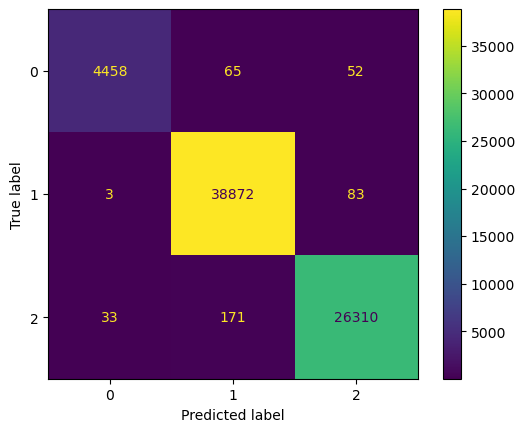

In [96]:
ConfusionMatrixDisplay(confusion_matrix(y_test.values, y_pred)).plot()

In [146]:
f'Autoencoder based neural network accuracy: {test_classifier(test_dataloader, nn_model, loss_fn)}'

'Autoencoder based neural network accuracy: 0.9942676056338031'

Therefore we achieve classifier for single cell RNA sequence with great accuracy of more than 99% on randomly selected test data.

However, it is not the main purpose ot the autoencoder. For these kind of data it may be beneficial to use autoencoder to reduce dimensiionality for other models.

In [26]:
autoencoder_model = torch.load('Autoencoder1.pth').cpu()

In [31]:
X_train_auto = autoencoder_model.encoder(torch.tensor(X_train)).cpu().detach().numpy()
X_test_auto = autoencoder_model.encoder(torch.tensor(X_test)).cpu().detach().numpy()

In [32]:
params = {"verbosity": 0,
"objective": "multi:softmax",
'booster': 'gbtree',
'lambda': 0.0010041351651543825,
 'alpha': 0.005709987636930291,
 'subsample': 0.9794808845466684,
 'colsample_bytree': 0.771828220298,
 'max_depth': 7,
 'min_child_weight': 3,
 'eta': 0.002806057913561531,
 'gamma': 9.457239856021425e-07,
 'grow_policy': 'depthwise'}

In [33]:
xgb_model = xgb.XGBClassifier(**params, n_jobs=-1)
xgb_model.fit(X_train_auto, y_train)
y_pred_auto = xgb_model.predict(X_test_auto)

In [35]:
f'XGBoost accuracy after autoencoder: {accuracy_score(y_test, y_pred_auto)}'

'XGBoost accuracy after autoencoder: 0.9954173626279498'

I should note that this variant works way faster (more than 10 times) than XGBoost on full data. And we get 0.5% accuracy increase as well, which means twice less errors (99% vs 99.5%)!

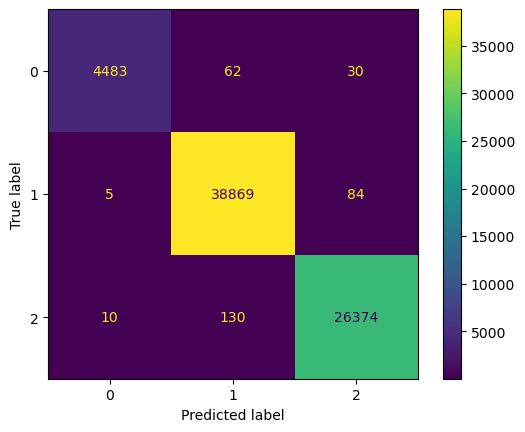

In [42]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_auto)).plot()

 I could create a simple neural network with the same architecture and see what it can do.

# Create full stacked neural network

In [44]:
class CustomNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Sequential(
            nn.Linear(254, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12)
        )
        self.linear2 = nn.Linear(12, 3)

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [114]:
nn_model_2 = CustomNeuralNetwork().to(device)

In [115]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn_model_2.parameters(), lr=1e-2)
epochs = 3
t_loss = []
t_acc = []
v_acc = []
for e in range(epochs):
    tup = train_classifier(train_dataloader, nn_model_2, loss_fn, optimizer)
    t_loss += [tup[0]]
    t_acc += [tup[1]]
    v_acc += [test_classifier(valid_dataloader, nn_model_2, loss_fn)]

for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-3
for e in range(epochs):
    tup = train_classifier(train_dataloader, nn_model_2, loss_fn, optimizer)
    t_loss += [tup[0]]
    t_acc += [tup[1]]
    v_acc += [test_classifier(valid_dataloader, nn_model_2, loss_fn)]

for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-4
for e in range(epochs):
    tup = train_classifier(train_dataloader, nn_model_2, loss_fn, optimizer)
    t_loss += [tup[0]]
    t_acc += [tup[1]]
    v_acc += [test_classifier(valid_dataloader, nn_model_2, loss_fn)]

for param_group in optimizer.param_groups:
    param_group['lr'] = 5e-4
for e in range(epochs):
    tup = train_classifier(train_dataloader, nn_model_2, loss_fn, optimizer)
    t_loss += [tup[0]]
    t_acc += [tup[1]]
    v_acc += [test_classifier(valid_dataloader, nn_model_2, loss_fn)]

for param_group in optimizer.param_groups:
    param_group['lr'] = 5e-5
for e in range(epochs):
    tup = train_classifier(train_dataloader, nn_model_2, loss_fn, optimizer)
    t_loss += [tup[0]]
    t_acc += [tup[1]]
    v_acc += [test_classifier(valid_dataloader, nn_model_2, loss_fn)]

for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-4
for e in range(epochs):
    tup = train_classifier(train_dataloader, nn_model_2, loss_fn, optimizer)
    t_loss += [tup[0]]
    t_acc += [tup[1]]
    v_acc += [test_classifier(valid_dataloader, nn_model_2, loss_fn)]

for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-5
for e in range(epochs):
    tup = train_classifier(train_dataloader, nn_model_2, loss_fn, optimizer)
    t_loss += [tup[0]]
    t_acc += [tup[1]]
    v_acc += [test_classifier(valid_dataloader, nn_model_2, loss_fn)]

0 1.0259432792663574 0.663
10 0.033096104860305786 0.984
20 0.010801686905324459 0.998
30 0.00836089812219143 0.997
40 0.01599503867328167 0.995
50 0.017757441848516464 0.997
60 0.004101490136235952 0.998
70 0.03174019604921341 0.996
80 0.003276586765423417 0.999
90 0.0035999442916363478 0.998
100 0.0012471673544496298 1.0
110 0.003533816896378994 0.999
120 0.004198281094431877 1.0
130 0.003824646817520261 0.998
140 0.007974720560014248 0.995
150 0.009475487284362316 0.996
0 0.004560644738376141 0.999
10 0.012229058891534805 0.998
20 0.0027434879448264837 0.999
30 0.002336122328415513 1.0
40 0.004485661629587412 0.999
50 0.01544119231402874 0.999
60 0.012842629104852676 0.996
70 0.0035076364874839783 0.999
80 0.0026316214352846146 1.0
90 0.007799520622938871 0.996
100 0.000897261721547693 1.0
110 0.04454740881919861 0.996
120 0.002852607751265168 0.999
130 0.0037277659866958857 0.999
140 0.0038721286691725254 0.999
150 0.0056456043384969234 0.997
0 0.0015707345446571708 1.0
10 0.001191

In [117]:
torch.save(nn_model_2, 'best_classifier.pth')

In [58]:
test_classifier(valid_dataloader, nn_model_2, loss_fn)

0.9993018867924528

## Neural network results

In [59]:
test_classifier(test_dataloader, nn_model_2, loss_fn)

0.9992112676056338

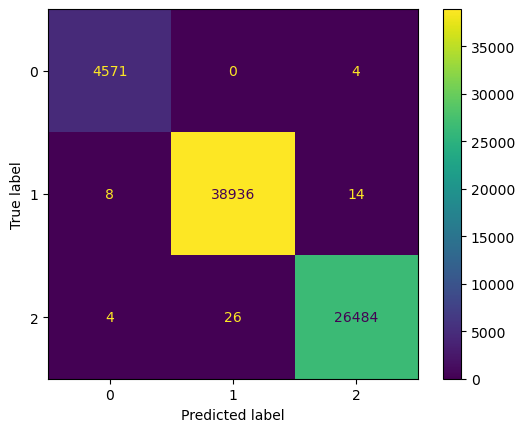

In [60]:
y_pred = nn_model_2(torch.tensor(X_test).to(device)).argmax(1).cpu().numpy()
ConfusionMatrixDisplay(confusion_matrix(y_test.values, y_pred)).plot()

Text(0, 0.5, 'Loss')

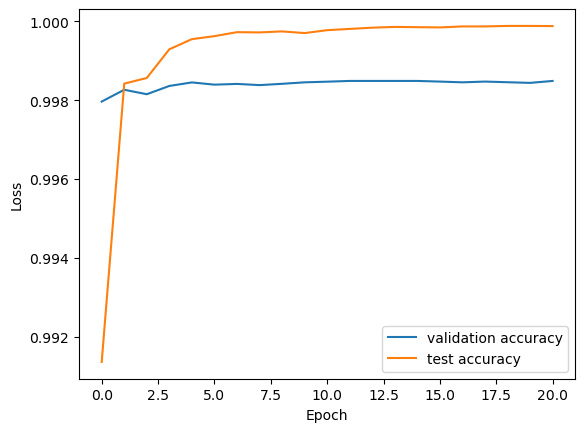

In [116]:
sns.lineplot(v_acc, label='validation accuracy')
sns.lineplot(t_acc, label='test accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Maybe it wasn't necessary to train this neural network for all 21 epochs. However it wasn't very long, and personally I enjoy the training process:)

It took way less time than search for hyperparameters for XGBoost.

# Final comparison

XGBoost with hyperparameters optimized by optuna

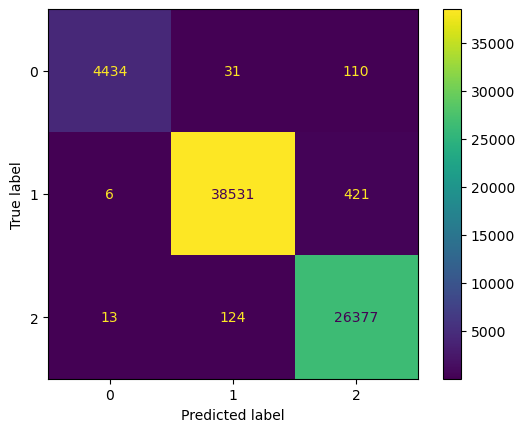

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_xgb)).plot()

In [150]:
f'XGBoost test accuracy score: {accuracy_score(y_test, y_pred_xgb)}'

'XGBoost test accuracy score: 0.9899353291361515'

Autoencoder-based neural network

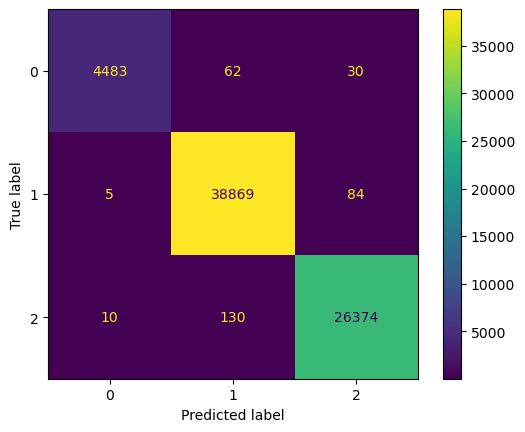

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_auto)).plot()

In [61]:
f'Autoencoder based neural network test accuracy: {accuracy_score(y_test, y_pred_auto)}'

'Autoencoder based neural network test accuracy: 0.9954173626279498'

Simple neural network

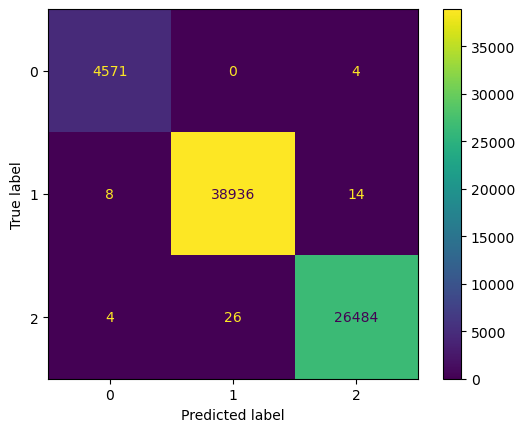

In [62]:
y_pred = nn_model_2(torch.tensor(X_test).to(device)).argmax(1).cpu().numpy()
ConfusionMatrixDisplay(confusion_matrix(y_test.values, y_pred)).plot()

In [63]:
f'Neural network test accuracy: {test_classifier(test_dataloader, nn_model_2, loss_fn)}'

'Neural network test accuracy: 0.9992112676056336'